# Spherical Triangulation
Here I discuss two methods used to triangulate a sphere:
1. the uniform grid in spherical coordinates method and
2. the unit octahedron method

The first method produces a mesh with highly populated poles. The second method produces a uniform mesh.

<img src="two methods.png" alt="twomethods" width="600"/>

# 1. Uniform grid in spherical coordinates triangulation method
The first method tessellates a sphere in a latitude-longitude fashion, with m divisions around
the equator and n divisions from pole to pole along each longitudinal line. A quadrilateral is
formed by two adjacent longitude lines and two adjacent latitude lines. At each pole, *m* triangles are formed. Each quadrilateral is then divided on the diagonal to form two triangles. Numerically, this is done by creating two vectors, one for the the azimuthal angle, denoted by $\theta$ and another for the polar angle denoted by $\phi$ in the spherical coordinate system subject to the following restrictions:

$$0\leq \theta\leq2\pi, \quad \quad 0\leq\phi\leq\pi$$

The azimuthal angle vector is divided into m equally spaced divisions. Similarly, the polar
angle vector is divided into n equally spaced divisions. The angle vectors can then be used to
determine the Cartesian coordinates of the vertices on the sphere using

$$x = r sin\phi cos\theta; \quad y = r sin\phi sin\theta; \quad z = r cos\phi$$

where r is the radius of the sphere. This process produces a sphere with a surface comprised of
$2m$ triangles at the pole and $m(n − 1)$ quadrilaterals elsewhere. Each quadrilateral is then divided on the diagonal to form two triangles. The total number of triangles generated on the sphere is given by

$$T(m,n) = 2m + 2m(n-1) = 2mn$$

The resulting mesh has a high concentration of triangles near the poles.


In [1]:
#importing relevant libraries
from math import *
import numpy as np
import matplotlib.pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

First we define the function sphereTriangulationGrid. The inputs *n* and *m* specify the number of longitudinal and latitudinal divisions respectively.

In [2]:
def sphereTriangulationGrid(n, m):
    theta = np.linspace(0, 2*pi, num = n)
    phi   = np.linspace(0, pi, num = m)
    M     = np.zeros((3,3,(n-1)*(m-1)*2))
    ind   = 0
    for i in range(n-1):
        for j in range(m-1, 0, -1):
            x1u = cos(theta[i])*sin(phi[j])
            y1u = sin(theta[i])*sin(phi[j])
            z1u = cos(phi[j])
            
            x2u = cos(theta[i+1])*sin(phi[j])
            y2u = sin(theta[i+1])*sin(phi[j])
            z2u = cos(phi[j])
            
            x3u = cos(theta[i])*sin(phi[j-1])
            y3u = sin(theta[i])*sin(phi[j-1])
            z3u = cos(phi[j-1])
            
            x1l = x2u
            y1l = y2u
            z1l = z2u
            
            x2l = x3u
            y2l = y3u
            z2l = z3u
            
            x3l = cos(theta[i+1])*sin(phi[j-1])
            y3l = sin(theta[i+1])*sin(phi[j-1])
            z3l = cos(phi[j-1])
            
            M[:,:,2*ind]   = np.array([[x1u, x2u, x3u], [y1u, y2u, y3u], [z1u, z2u, z3u]])
            M[:,:,2*ind+1] = np.array([[x1l, x2l, x3l], [y1l, y2l, y3l], [z1l, z2l, z3l]])
            ind += 1
    return M                            #outputs a 3x3xN array; each 3x3 subarray represents a triangle.. 
                                        #...on the sphere where each row represents the xyz coordinates..
                                        #...of each vertex          

# 2. Uniform triangulation of sphere using octahedrons
Another method of uniformly triangulating the surface of a sphere is by recursively subdividing the triangles of a unit octahedron until the desired resolution is obtained, then mapping the resulting polyhedron onto the unit sphere.

<img src="Octahedron.png" alt="octahedron" width="600"/>
(i) Splitting each triangle into 3 subtriangles, (ii) projecting the vertices onto the unit sphere, (iii) the resulting polyhedron, (iv) top view of the resulting polyhedron. (a) 0th iteration, (b) 1st iteration, and (c) 2nd iteration.

With each iteration, the number of triangles increases by a factor of 4, which gives the following expression for the total number of triangles:

$$T(n) = 2^{2n+3}$$

where $n$ is the $nth$ iteration. The octahedron triangulation method falls under a large class of triangulation methods that similarily use polyhedrons to divide the surface of a sphere into uniformly distributed triangles.


First we define the function sphereTriangulation, which triangulates a unit sphere using a unit octahedron. *iterations* specifies the number of iterations and *radius* specificies the radius of the sphere. Ap, Bp, and Cp are the triangle vertex vectors.

In [3]:
#arsNorm(A) and arsUnit(A,radius) are used to project and normalise the vertices onto the sphere
def arsNorm(A):
    return np.sqrt(np.multiply(A[:,0],A[:,0]) + np.multiply(A[:,1],A[:,1]) + np.multiply(A[:,2],A[:,2]))

def arsUnit(A, radius):
    normOfA = arsNorm(A)
    return  radius*(np.divide(A,np.transpose(np.vstack((normOfA,normOfA,normOfA)))))

#this is the main triangulation function
def sphereTriangulation(iterations, radius):
    #basic Octahedron
    A = np.array([1,0,0])
    B = np.array([0,1,0])
    C = np.array([0,0,1])
    #from +-ABC create initial triangles which define the octahedron
    triangles = np.vstack((A,B,C,A,B,-C,-A,B,C,-A,B,-C,-A,-B,C,-A,-B,-C,A,-B,C,A,-B,-C)) 
    #for simplicity, we split the triangles into ABC points
    selector  = np.arange(1,triangles.shape[0]-1,3)
    Ap = triangles[selector-1]
    Bp = triangles[selector]
    Cp = triangles[selector+1]
    
    #for every iteration divide every triangle into three new triangles
    #        ^ C
    #       / \
    # AC/2 /_4_\CB/2
    #     /\ 3 /\
    #    / 1\ /2 \
    # A /____V____\B           
    #       AB/2
    #the new triangle stack is given by [[A, AB/2, AC/2]; [AB/2, B, CB/2]; [AC/2, AB/2, CB/2]; [AC/2, CB/2, C]] 
    for iteration in range(1, iterations+1):
        AB_2 = arsUnit((Ap+Bp)/2,radius)
        AC_2 = arsUnit((Ap+Cp)/2,radius)
        CB_2 = arsUnit((Cp+Bp)/2,radius)
        Ap   = np.vstack((Ap, AB_2, AC_2, AC_2))   #points from the 4 triangles... same for Bp and Cp
        Bp   = np.vstack((AB_2, Bp, AB_2, CB_2))
        Cp   = np.vstack((AC_2, CB_2, CB_2, Cp))
        
    M = np.array([Ap,Bp,Cp])            #outputs a 3x3xN array; each 3x3 subarray represents a triangle.. 
    M = np.transpose(M,(2,0,1))         #...on the sphere where each row represents the xyz coordinates..
                                        #...of each vertex          
    return M

Let us test out our function by drawing the first quadrant of the triangulated sphere

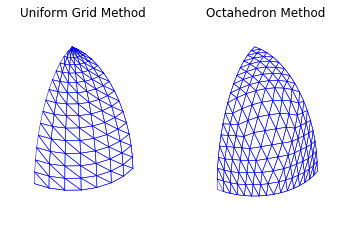

In [4]:
iterations, radius, n, m = 4, 1, 30, 30                

M1 = sphereTriangulationGrid(n,m)
M2 = sphereTriangulation(iterations,radius)
#extract the triangle vertices from M1 and M2
A1, B1, C1 = M1[:,0,:], M1[:,1,:], M1[:,2,:]
A2, B2, C2 = M2[:,0,:], M2[:,1,:], M2[:,2,:]
#setup figure and subplots
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d') 
plt.axis('off')
ax2 = fig.add_subplot(122, projection='3d')
plt.axis('off')
ax1.title.set_text('Uniform Grid Method')
ax2.title.set_text('Octahedron Method')
#only show one quadrant
A1[A1<0], B1[B1<0], C1[C1<0] = np.nan, np.nan, np.nan
A2[A2<0], B2[B2<0], C2[C2<0] = np.nan, np.nan, np.nan
ax1.set_zlim(0, 1)
ax1.view_init(elev=25., azim=30)
ax2.set_zlim(0, 1)
ax2.view_init(elev=25., azim=30)
#draw each triangle
for i in range(1, A1.shape[1]):
    triangle1 = np.vstack((A1[:,i], B1[:,i], C1[:,i], A1[:,i]))
    ax1.plot(triangle1[:,0],triangle1[:,1],triangle1[:,2], 'b-', linewidth = 0.5)
for i in range(1, A2.shape[1]):
    triangle2 = np.vstack((A2[:,i], B2[:,i], C2[:,i], A2[:,i]))
    ax2.plot(triangle2[:,0],triangle2[:,1],triangle2[:,2], 'b-', linewidth = 0.5)

# Solid Angle and Centroid Calculation

The output 3d array, M, can be used to calculate the centroid of each of the triangles as well as the solid angles of the triangles.

To calculate the solid angle, I used the formula from [this paper](http://ieeexplore.ieee.org/document/4121581/) where the solid angle $\Omega$, measured in steradians, is calculated using

$${tan}\left (\frac{1}{2} \Omega   \right ) = \frac{{det} \left [(\mathbf{R_{1}})(\mathbf{R_{2}})(\mathbf{R_{3}})  \right ]}{R_{1}R_{2}R_{3}+\mathbf{\left (R_{1}\cdot R_{2}  \right )}R_{3} + \mathbf{\left (R_{1}\cdot R_{3}  \right )}R_{2} + \mathbf{\left (R_{2}\cdot R_{3}  \right )}R_{1}}$$

where $\mathbf{R_{i}}$ are the triangle vertex vectors, $R_{i}$ are the magnitudes of the vectors and ${det} \left [(\mathbf{R_{1}})(\mathbf{R_{2}})(\mathbf{R_{3}})  \right ]$ is the determinant of a matrix constructed from the column vectors.

The function SolidAngle takes an input matrix M of size 3x3xN, which is the matrix calculated by the triangulation functions aboove. The output is a vector of the solid angles of the triangles.


In [5]:
def SolidAngle(M):
    #initialise the solid angle array
    s = np.shape(M)
    omega = np.zeros([1,s[2]])
    #for each triangle we calculate the individual solid angles and add them to the solid angle array
    for i in range(s[2]):
        X = M[:,:,i]
        R1 = X[:,0]
        R2 = X[:,1]
        R3 = X[:,2]
        n1 = np.linalg.norm(R1)
        n2 = np.linalg.norm(R2)
        n3 = np.linalg.norm(R3)
        D = np.absolute(np.linalg.det(X))
        A = 1/((n1*n2*n3) + ((np.dot(R1,R2)*n3) + (np.dot(R1,R3)*n2) + (np.dot(R2,R3)*n1)))
        A = D * A
        omega[0,i] = np.arctan(A)*2             
    return omega


We can check if the function works correctly by testing it on our 3D array of triangles M. We should get a vector of solid angles where the sum of the vector elements is equal to $4\pi$


In [6]:
M1 = sphereTriangulationGrid(33,33)
M2 = sphereTriangulation(4,1)
print(np.sum(SolidAngle(M1))/pi)
print(np.sum(SolidAngle(M2))/pi)

4.0
4.000000000000001



The centroid of each spherical triangle can be found by first finding the centroid of the non-spherical triangles, denoted by $\mathbf{r_{o}}$, using

$$\mathbf{r_{o}} = \frac{1}{3}\mathbf{R_{1}} + \frac{1}{3}\mathbf{R_{2}} + \frac{1}{3}\mathbf{R_{3}}$$

where $\mathbf{R_{i}}$ is the vector representing each vertex (same vectors used in the solid angle calculation. Similar to the solid angle calculation, these vectors are represented by the *ith* row of M (the output of the triangulation function). 

The centroid of the spherical triangle, $\mathbf{r}$ is then obtained by projecting $\mathbf{r_{o}}$ onto the sphere, which, in the case of the unit sphere, is done by normalising $\mathbf{r_{o}}$:

$$\mathbf{r} = \frac{\mathbf{r_{o}}}{\left \| \mathbf{r_{0}} \right \|}$$

where $\left \| \mathbf{r_{0}} \right \|$ is the Euclidean norm of $\mathbf{r_{0}}$

The function SphericalTriCentroid takes an input M (the triangles matrix) and outputs the xyz coordinates of the centroids, C, of the spherical triangles.

In [7]:
def SphericalTriCentroid(M):
    #initialise the centroid 2d array
    s = M.shape
    C = np.zeros([3,s[2]])
    for i in range(s[2]):
        #getting the vertex vectors of the triangles
        X = M[:,:,i]
        R1 = X[:,0]
        R2 = X[:,1]
        R3 = X[:,2]
        #calculating xyz position of centres and projecting onto the sphere
        temp = (R1+R2+R3)/3
        temp = temp/np.linalg.norm(temp)
        #updating C with the xyz coordinates of the centroids
        C[:,i] = temp
    return C


We can check our function by plotting the centroids of the spherical triangles for both the uniform grid triangulation and octahedron triangulation


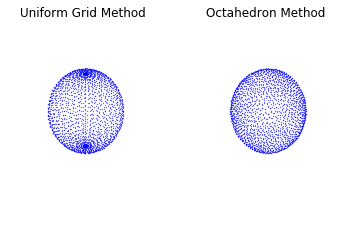

In [8]:
C1 = SphericalTriCentroid(M1)
C2 = SphericalTriCentroid(M2)

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d') 
ax1.plot(C1[0,:],C1[1,:],C1[2,:], 'b.', markersize=.5)
plt.axis('off')
ax1.set_zlim(-2,1)
ax1.view_init(elev=25., azim=30)

ax2 = fig.add_subplot(122, projection='3d') 
ax2.plot(C2[0,:],C2[1,:],C2[2,:], 'b.', markersize=.5)
plt.axis('off')
ax2.set_zlim(-2, 1)
ax2.view_init(elev=25., azim=30)
ax1.title.set_text('Uniform Grid Method')
ax2.title.set_text('Octahedron Method')
